# Import and Cleaning

In [1]:
# adding path to import custom functions
import sys
sys.path.append("/home/artur/code/masters-project/main_project/notebooks/model_creation")

In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter, gmtime, strftime

from functions import remove_high_corr, scale_variables, best_params_grid, calculate_confusion_matrix, plot_roc_auc_curve, bart_auc_scorer, make_label

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedKFold, train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

from ISLP.bart import BART

import session_info 

In [3]:
data = pd.read_csv("../data/pre_processed_pdb_rdkit.csv")
data.head()

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
Y = data["fda_approved"]
Y = Y.astype(float)
Y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: oral, dtype: float64

In [5]:
X = data.iloc[:, 14:-1]
X.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.055556,-0.333333,6.055556,0.333333,0.242956,59.072,54.032,59.048347,24.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.451389,-0.439815,9.451389,0.439815,0.301333,75.067,70.027,75.032028,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.229167,-0.939815,9.229167,0.939815,0.256644,76.055,72.023,76.027277,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.951389,0.683642,4.951389,0.683642,0.419021,77.152,70.096,77.029920,26.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.555556,-0.611111,9.555556,0.611111,0.373753,78.136,72.088,78.013936,26.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# separate train an test datasets

np.random.seed(983538)
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Constant Variables

In [7]:
DESCRIPTOR_TYPE = "rdkit"

# Scaling datsets

The datasets are being scaled to be used, when necessary, scaled

In [8]:
# TRAIN

x_train_scaled = scale_variables(x_train)

# adding constant
x_train_scaled = sm.add_constant(x_train_scaled)

x_train_scaled.head()

,const,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.0,-0.233633,-0.121012,-0.233633,-0.434170,-0.087580,-0.959181,-0.953438,-0.958414,-0.898339,...,-0.169674,-0.255676,-0.257462,-0.110038,-0.106714,-0.11948,-0.143032,-0.14292,-0.197891,-0.209697
1,1.0,-0.670808,0.250583,-0.670808,0.038471,-0.274533,-1.121891,-1.127000,-1.121163,-1.050373,...,-0.169674,-0.255676,-0.257462,-0.110038,-0.106714,-0.11948,-0.143032,-0.14292,-0.197891,-0.209697
2,1.0,-0.070931,0.310987,-0.070931,-0.590331,-0.876620,-0.703534,-0.680740,-0.702678,-0.655084,...,-0.169674,-0.255676,-0.257462,-0.110038,-0.106714,-0.11948,-0.143032,-0.14292,-0.197891,-0.209697
3,1.0,-0.053017,0.556520,-0.053017,0.628262,0.832885,-0.772753,-0.779561,-0.772075,-0.715898,...,-0.169674,-0.255676,-0.257462,-0.110038,-0.106714,-0.11948,-0.143032,-0.14292,-0.197891,-0.209697
4,1.0,-0.546982,0.300342,-0.546982,-0.538983,0.305230,-0.877443,-0.903725,-0.876722,-0.776711,...,-0.169674,-0.255676,-0.257462,-0.110038,-0.106714,-0.11948,-0.143032,-0.14292,-0.197891,-0.209697


In [9]:
# TEST

x_test_scaled = scale_variables(x_test)

# adding constant
x_test_scaled = sm.add_constant(x_test_scaled)

x_test_scaled.head()

,const,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.0,-0.108788,0.548420,-0.108788,-0.574177,0.375218,-1.172675,-1.193258,-1.171984,-1.082982,...,-0.188113,-0.231362,-0.223409,-0.131024,-0.122431,-0.103252,-0.162879,-0.133774,-0.18454,-0.19868
1,1.0,0.120416,0.352366,0.120416,-0.441687,0.056207,-0.246807,-0.285004,-0.246079,-0.133643,...,-0.188113,-0.231362,-0.223409,-0.131024,-0.122431,-0.103252,-0.162879,-0.133774,-0.18454,-0.19868
2,1.0,-0.069332,-0.115631,-0.069332,-0.222720,-0.681442,-0.320889,-0.268118,-0.325194,-0.478857,...,-0.188113,-0.231362,-0.223409,-0.131024,-0.122431,-0.103252,-0.162879,-0.133774,-0.18454,-0.19868
3,1.0,-3.291419,1.525143,-3.291419,3.655933,0.611760,-0.581288,-0.595412,-0.580779,-0.536393,...,-0.188113,-0.231362,-0.223409,-0.131024,-0.122431,-0.103252,-0.162879,-0.133774,-0.18454,-0.19868
4,1.0,-2.812025,1.443957,-2.812025,3.130999,0.805018,-0.575088,-0.679050,-0.574567,-0.392554,...,-0.188113,-0.231362,-0.223409,-0.131024,-0.122431,-0.103252,-0.162879,-0.133774,-0.18454,-0.19868


# Logistic Regression

## Model Constant Variables

In [10]:
model_name_title = "Logistic Regression"
model_name_path = "logistic_regression"

## Cross Validation

Here, I will use the best_params_grid function, which looks for the best hyperparameters, using CV. There are no hyperparameters in Logistic Regression, so this function will only perform CV.

In [11]:
model_params_lr = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {}
    }
}

In [12]:
gs_result_lr, gs_result_lr_full = best_params_grid(x_train_scaled, y_train, model_params_lr)

Starting Grid Search for Logistic Regression: 17:40


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Finished Grid Search for Logistic Regression: 17:40
Tempo de execução:  0.0 minutos


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

In [13]:
gs_result_lr

,model,best_score,best_params
0,Logistic Regression,0.656347,{}


## Fitting Model to Train Dataset

To fit the model, I will use the Logit function, from the statsmodel library, because it gives more information about feature importance.

In [14]:
# adjusting y_train index and type

y_train.index = range(0, x_train_scaled.shape[0])

In [15]:
# calculatin model
log_reg = sm.Logit(y_train, x_train_scaled).fit()
log_reg_results = log_reg.summary()

         Current function value: 0.505730
         Iterations: 35


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Make Predictions

In [16]:
y_predict_lr_prob = log_reg.predict(x_test_scaled)

## Test Error

First, I need to change the prediction from probabilities to labels, using a cutoff of 0.5

In [17]:
# converting probability to labels
def convert_prob_to_label(prob, cutoff = 0.5):
    label = None
    if prob > cutoff:
        label = 1
    else:
        label = 0
    return label

In [18]:
y_predict_labels_lr = list(map(convert_prob_to_label, y_predict_lr_prob))
y_predict_labels_lr = np.asarray(y_predict_labels_lr)

In [19]:
mis_rate_lr, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_labels_lr,
)

Misclassification rate: 0.4747


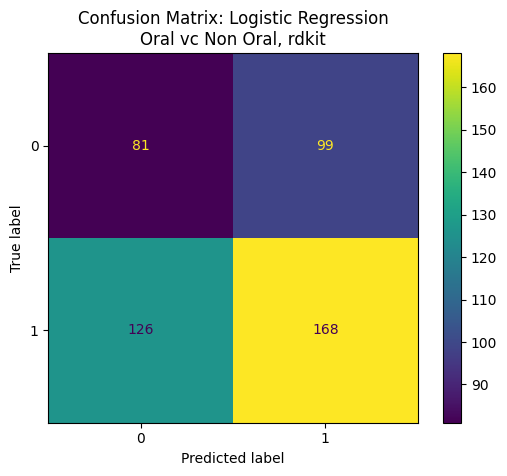

In [20]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

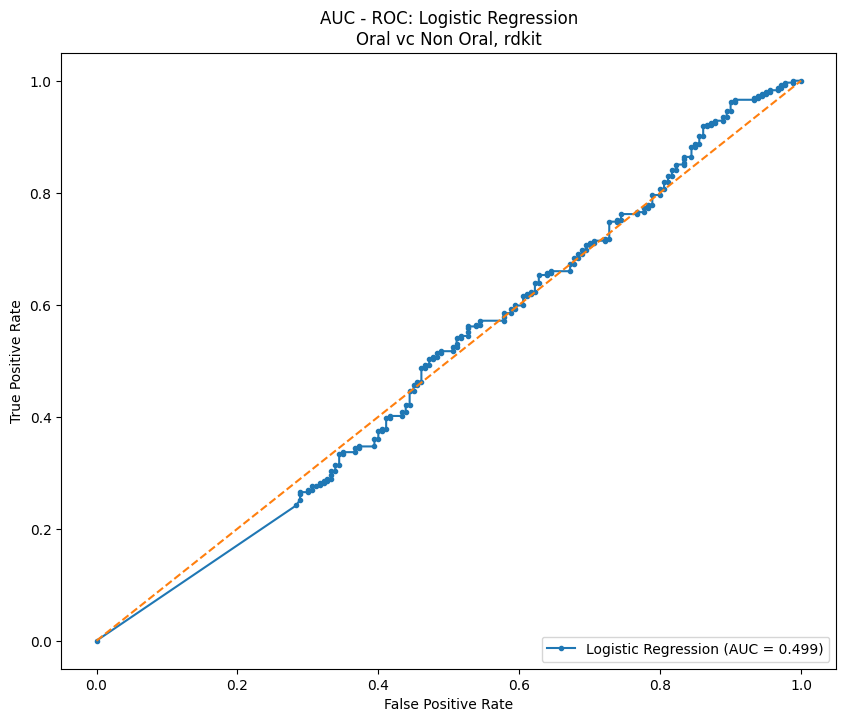

In [21]:
auc_lr = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_lr_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

In [22]:
# converting results summary to pandas dataframe
results_log_reg_html = log_reg_results.tables[1].as_html()
results_log_reg_df = pd.read_html(results_log_reg_html, header=0, index_col=0)[0]
print(results_log_reg_df.shape)
results_log_reg_df.head()

(202, 6)


,coef,std err,z,P>|z|,[0.025,0.975]
const,0.9702,2373.281,0.000,1.000,-4650.576,4652.516
MaxEStateIndex,0.0506,NaN,NaN,NaN,NaN,NaN
MinEStateIndex,-0.2338,0.232,-1.010,0.313,-0.688,0.220
MaxAbsEStateIndex,0.0506,NaN,NaN,NaN,NaN,NaN
MinAbsEStateIndex,0.0005,0.116,0.004,0.997,-0.228,0.229


In [23]:
important_features_lr = results_log_reg_df[results_log_reg_df["P>|z|"] < 0.05]
print(important_features_lr.shape)
important_features_lr

(15, 6)


,coef,std err,z,P>|z|,[0.025,0.975]
qed,0.2926,0.143,2.045,0.041,0.012,0.573
HeavyAtomMolWt,389.5948,173.738,2.242,0.025,49.075,730.115
NumValenceElectrons,124.4838,53.120,2.343,0.019,20.370,228.597
BCUT2D_LOGPLOW,-0.5446,0.277,-1.965,0.049,-1.088,-0.001
BalabanJ,-0.5684,0.243,-2.342,0.019,-1.044,-0.093
Chi0n,76.2535,38.429,1.984,0.047,0.933,151.574
HallKierAlpha,-4.9456,2.052,-2.410,0.016,-8.968,-0.923
Kappa2,2.5264,1.117,2.262,0.024,0.338,4.715
HeavyAtomCount,-186.1460,79.497,-2.342,0.019,-341.957,-30.335
NOCount,-23.3273,7.617,-3.063,0.002,-38.256,-8.399


## Saving Results

In [24]:
# creating dataset to store final results from each model
final_results = pd.DataFrame(columns=["model_name", "cv_auc", "test_mis_rate", "test_auc"])

In [25]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_lr["best_score"][0],
    mis_rate_lr,
    auc_lr
]
final_results

,model_name,cv_auc,test_mis_rate,test_auc
0,Logistic Regression,0.656347,0.474684,0.498743


In [26]:
important_features_lr.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# TREES

# Decision Tree

## Model Constant Variables

In [27]:
model_name_title = "Decision Tree"
model_name_path = "decision_tree"

## Hyperparameter Fine Tuning

In [28]:
model_params = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [1, 5, 10, 20, 50, 100, 150],
            'ccp_alpha': [0, 0.0001, 0.001, 0.1, 0.5, 1]
        }
    }
}

In [29]:
gs_result_dt, gs_result_dt_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Decision Tree: 17:41
Finished Grid Search for Decision Tree: 17:45
Tempo de execução:  4.7 minutos


In [30]:
gs_result_dt

,model,best_score,best_params
0,Decision Tree,0.623894,"{'ccp_alpha': 0, 'criterion': 'gini', 'max_dep..."


## Fitting Tree

In [31]:
decision_tree_params = gs_result_dt.iloc[0,2]
decision_tree_params

{'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 5}

In [32]:
decision_tree = DecisionTreeClassifier(**decision_tree_params).fit(x_train_scaled, y_train)

## Make Predictions

In [33]:
y_predict_dt_label = decision_tree.predict(x_test_scaled)
y_predict_dt_prob = decision_tree.predict_proba(x_test_scaled)[:, 1]

## Test Error

In [34]:
mis_rate_dt, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_dt_label,
)

Misclassification rate: 0.3629


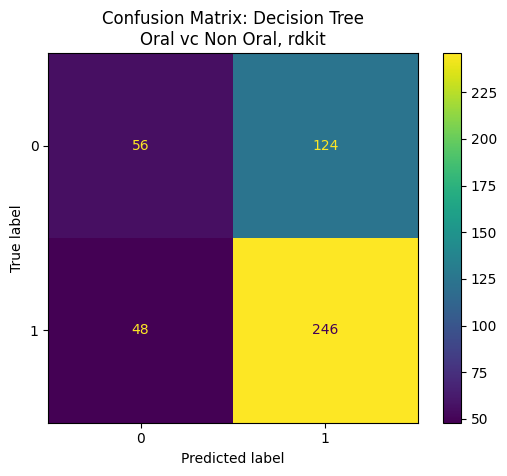

In [35]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

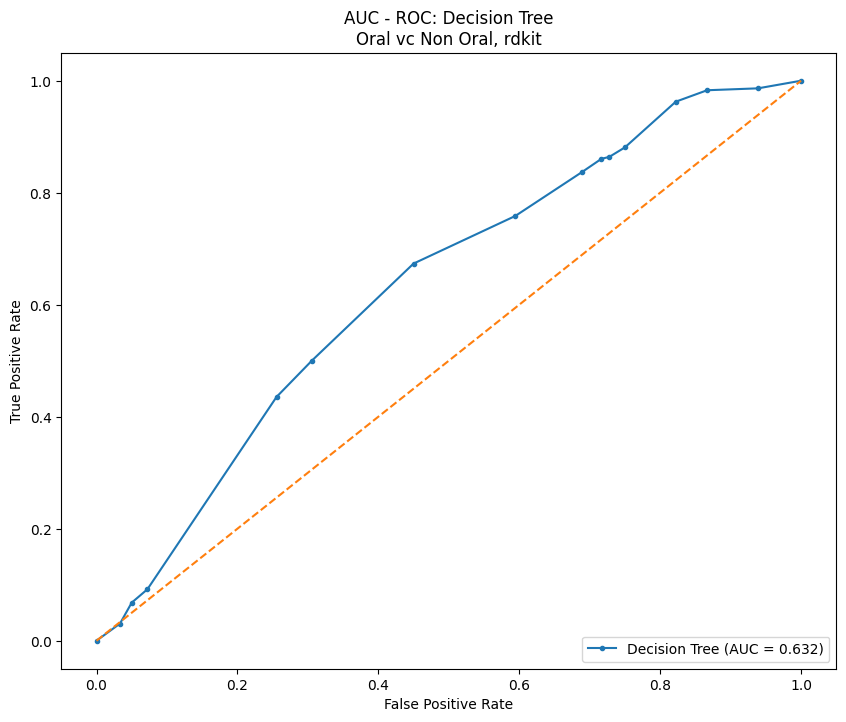

In [36]:
auc_dt = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_dt_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Visualizing the Tree

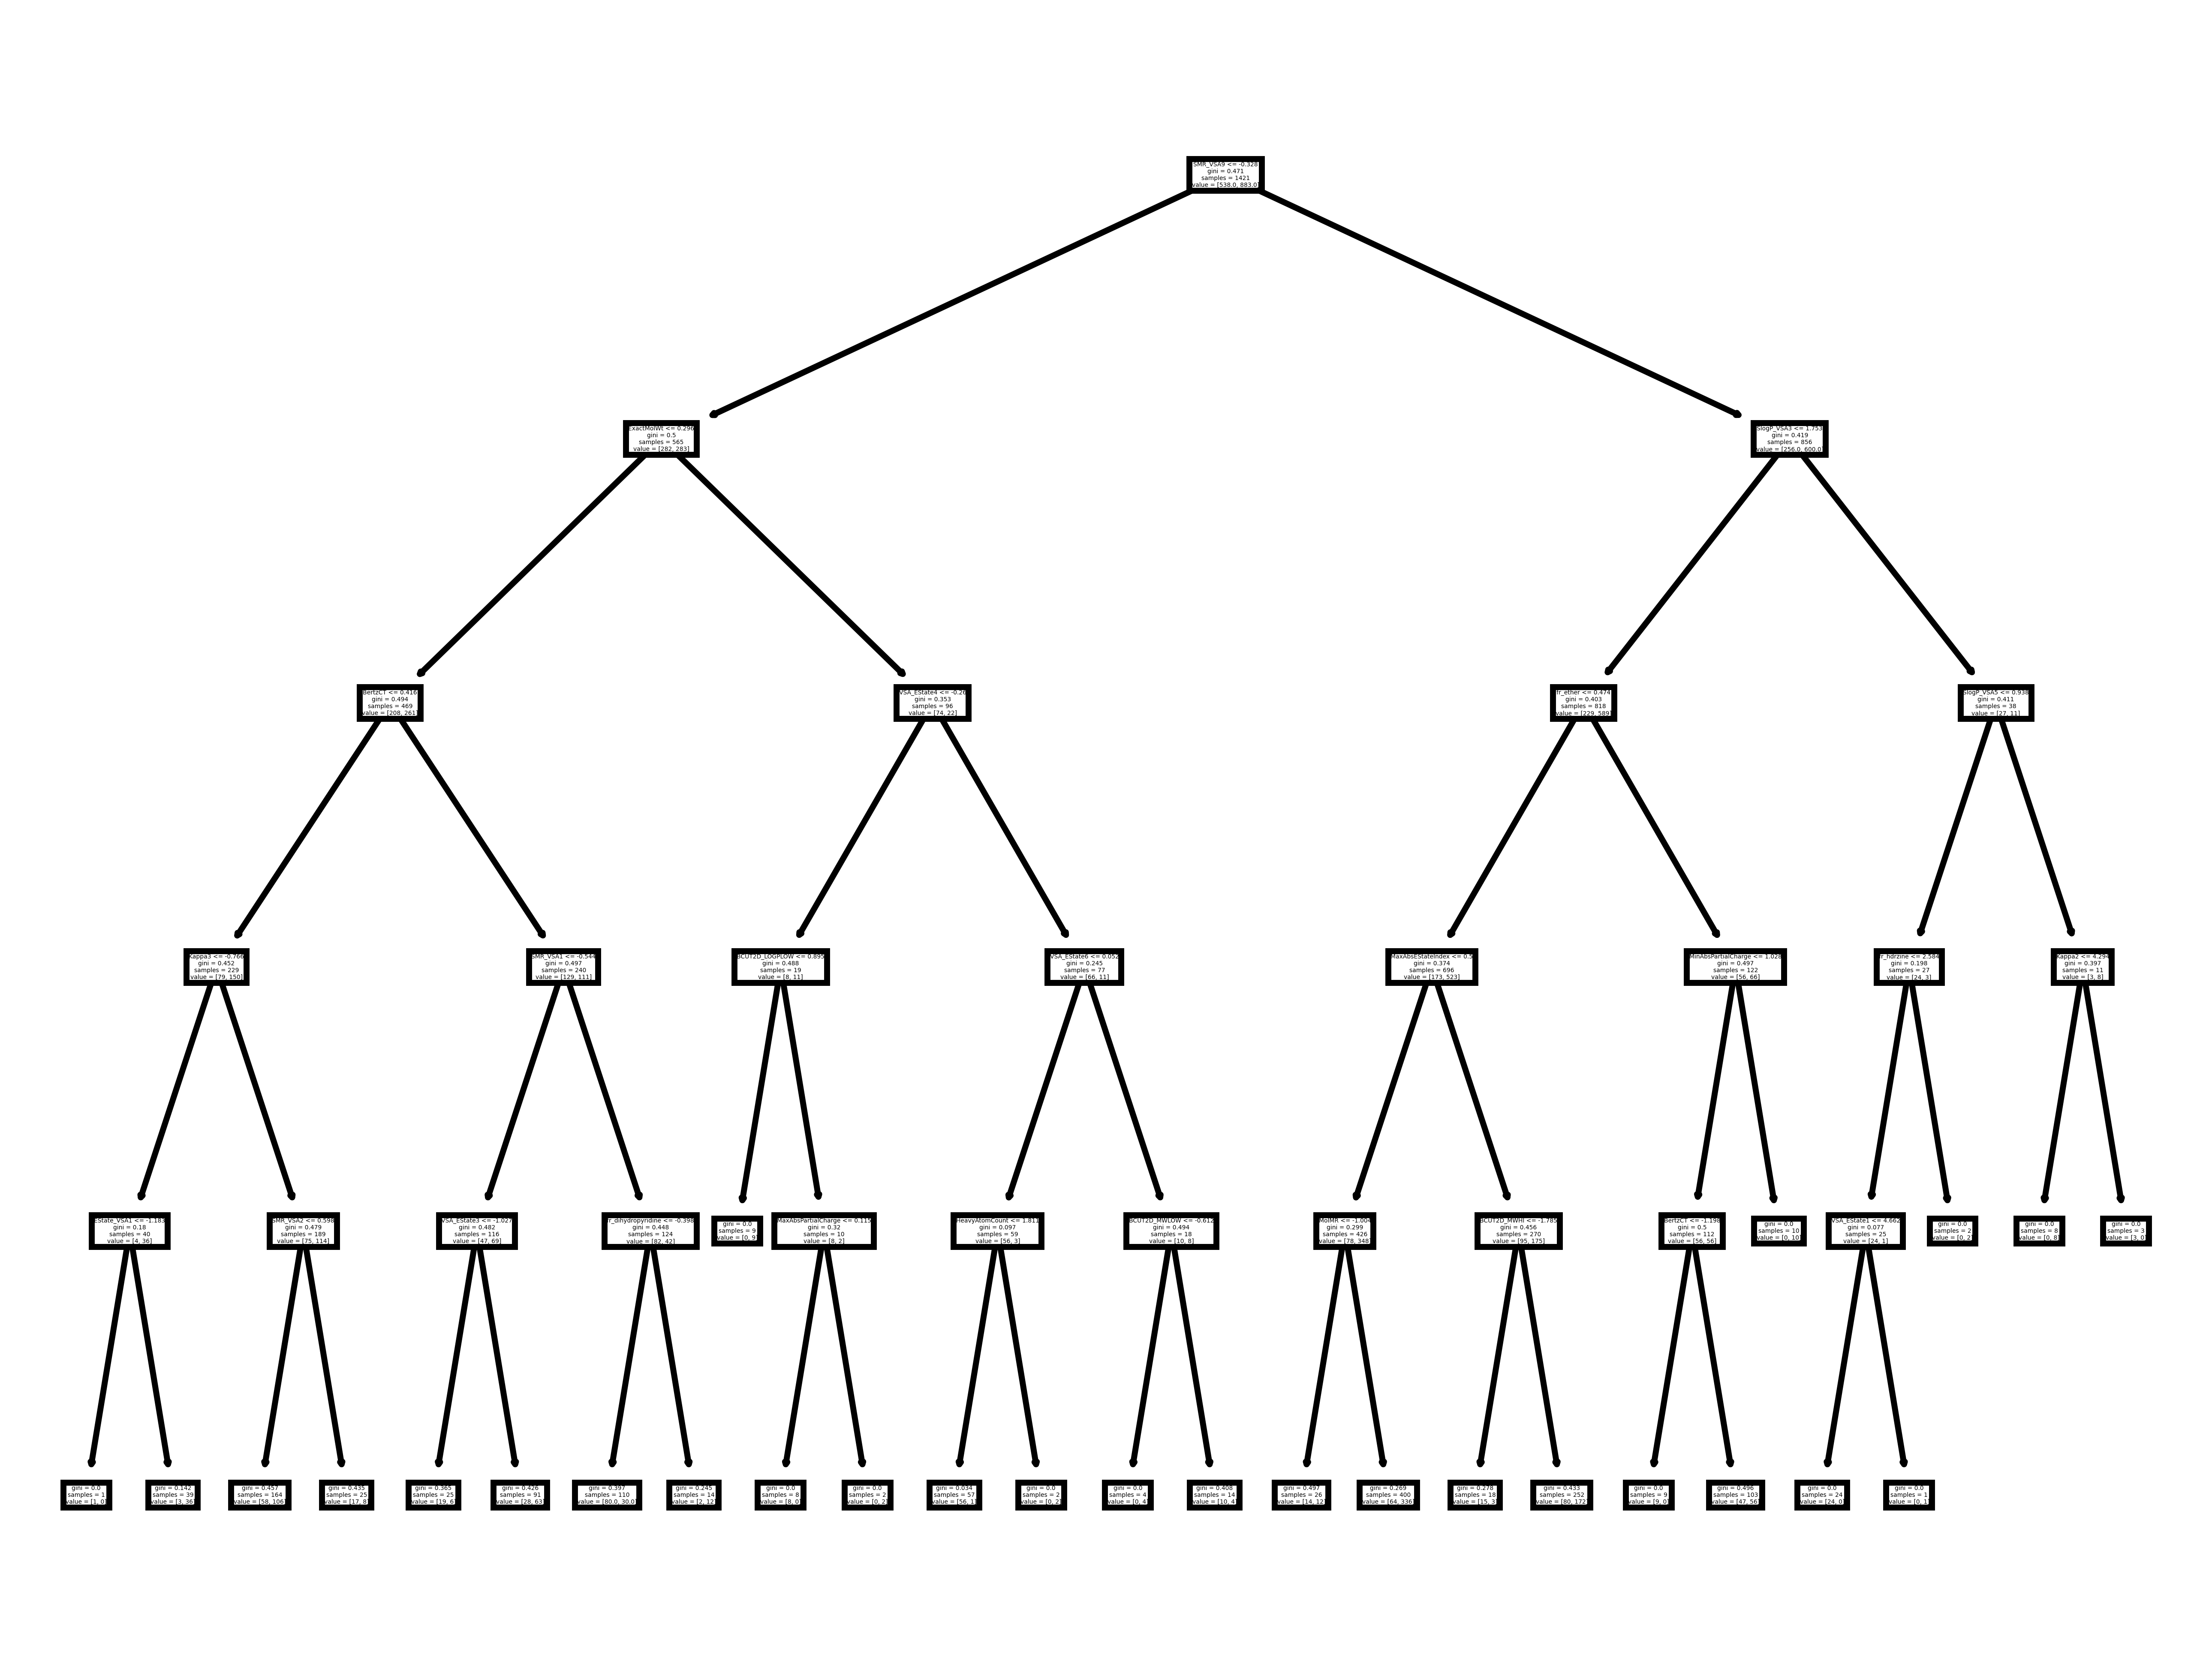

In [37]:
fig, ax = plt.subplots()
fig.dpi = 1000

tree.plot_tree(decision_tree, ax=ax, feature_names=list(x_train.columns))
plt.show()

fig.savefig(f"imgs/decision_tree_{DESCRIPTOR_TYPE}", dpi=1000)

## Feature Importance

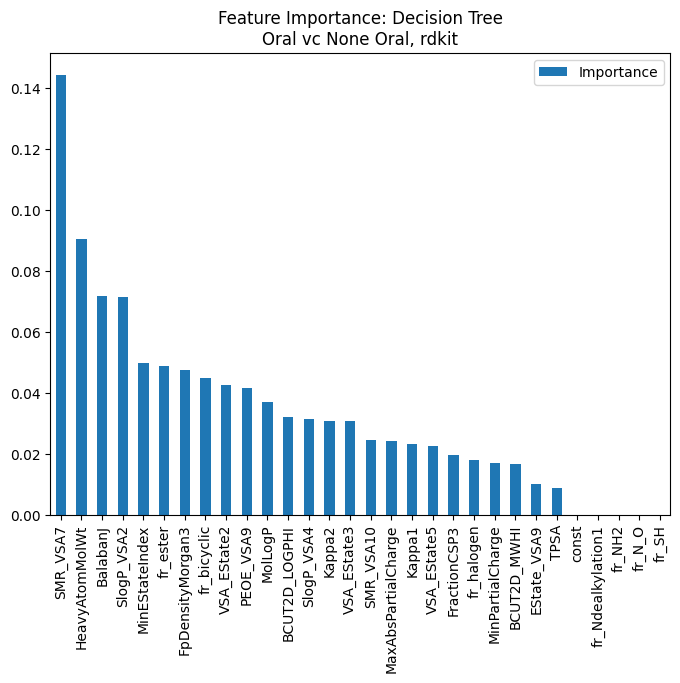

In [38]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(decision_tree.feature_importances_, index=x_train_scaled.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [39]:
important_features_dt = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_dt

,Importance
TPSA,0.008799
EState_VSA9,0.010168
BCUT2D_MWHI,0.016811
MinPartialCharge,0.016946
fr_halogen,0.018076
FractionCSP3,0.019753
VSA_EState5,0.022630
Kappa1,0.023108
MaxAbsPartialCharge,0.024308
SMR_VSA10,0.024469


## Saving Results

In [40]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_dt["best_score"][0],
    mis_rate_dt,
    auc_dt
]
final_results

,model_name,cv_auc,test_mis_rate,test_auc
0,Logistic Regression,0.656347,0.474684,0.498743
1,Decision Tree,0.623894,0.362869,0.632483


In [41]:
important_features_dt.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Random Forest and Bagging

Bagging is just Random Forest, in which max_features is equal to the total number of features. Therefore, bagging will be done in the RF algorithm, and compared to RF.

## Model Constant Variables

In [42]:
model_name_title = "Random Forest"
model_name_path = "random_forest"

## Hyperparameter Fine Tuning

In [43]:
model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 500, 1000], # number of trees
            'max_depth': [10, 50, 100],
            'max_features': ["sqrt", "log2", x_train.shape[1]], # m, number of features considered in split. When it is equal to all predictor of dataset, it is bagging
            'ccp_alpha': [0, 0.1, 0.5, 1]
        }
    }
}

In [44]:
gs_result_rf, gs_result_rf_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Random Forest: 17:45
Finished Grid Search for Random Forest: 03:00
Tempo de execução:  555.1 minutos


In [45]:
gs_result_rf

,model,best_score,best_params
0,Random Forest,0.734871,"{'ccp_alpha': 0, 'max_depth': 100, 'max_featur..."


## Fitting Model

In [46]:
random_forest_params = gs_result_rf.iloc[0,2]
random_forest_params

{'ccp_alpha': 0,
 'max_depth': 100,
 'max_features': 'log2',
 'n_estimators': 1000}

In [47]:
random_forest = RandomForestClassifier(**random_forest_params).fit(x_train_scaled, y_train)

## Make Predictions

In [48]:
y_predict_rf_label = random_forest.predict(x_test_scaled)
y_predict_rf_prob = random_forest.predict_proba(x_test_scaled)[:, 1]

## Test Error

In [49]:
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_rf_label,
)

Misclassification rate: 0.3122


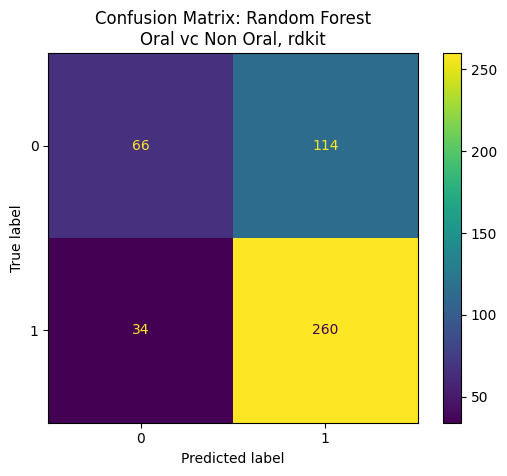

In [50]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

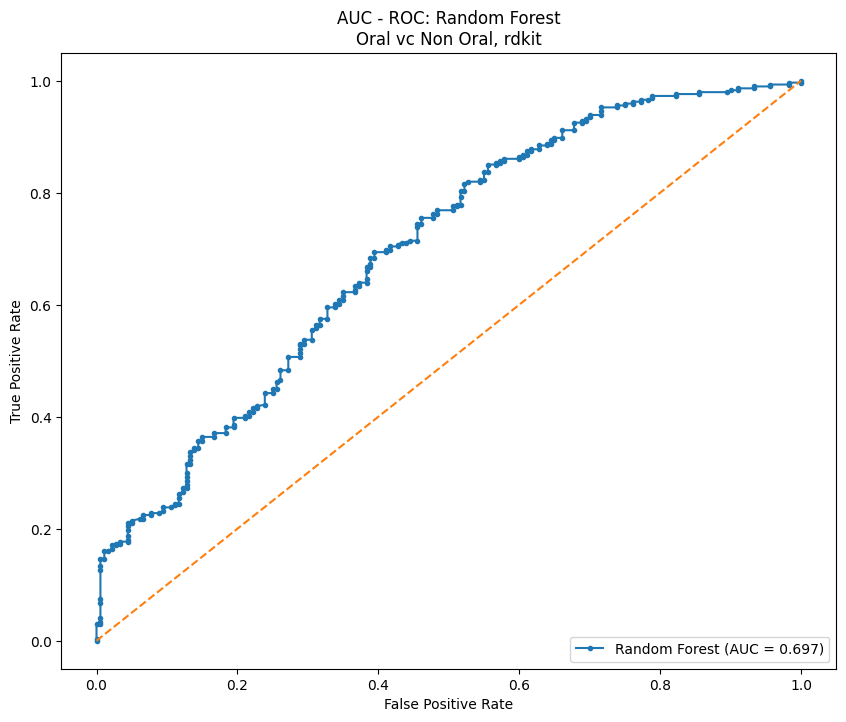

In [51]:
auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

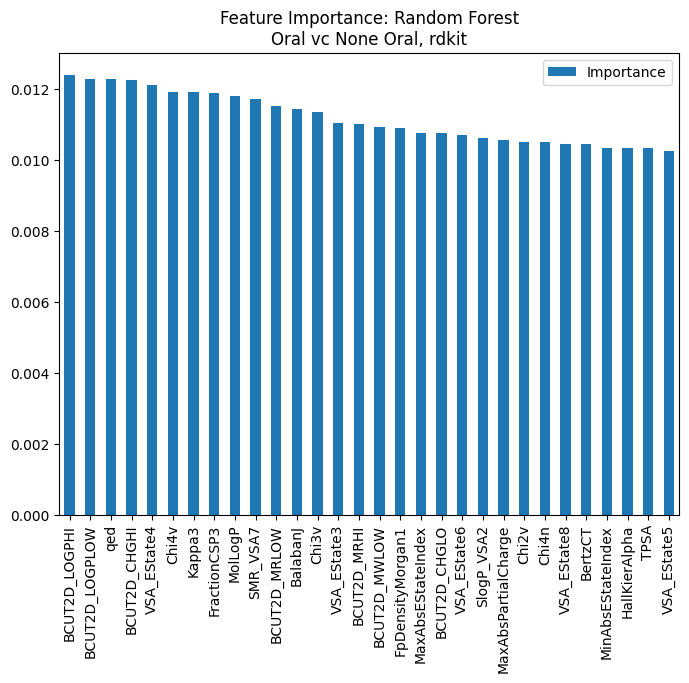

In [52]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(random_forest.feature_importances_, index=x_train_scaled.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [53]:
important_features_rf = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_rf

,Importance
fr_azide,0.000002
Ipc,0.000002
NumRadicalElectrons,0.000006
fr_azo,0.000010
fr_nitroso,0.000024
...,...
VSA_EState4,0.012114
BCUT2D_CHGHI,0.012250
qed,0.012285
BCUT2D_LOGPLOW,0.012287


## Saving Results

In [54]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_rf["best_score"][0],
    mis_rate_rf,
    auc_rf
]
final_results

,model_name,cv_auc,test_mis_rate,test_auc
0,Logistic Regression,0.656347,0.474684,0.498743
1,Decision Tree,0.623894,0.362869,0.632483
2,Random Forest,0.734871,0.312236,0.697194


In [55]:
important_features_rf.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Boosting

## Model Constant Variables

In [56]:
model_name_title = "Gradiant Boosting"
model_name_path = "boosting"

## Hyperparameter Fine Tuning

In [57]:
model_params = {
    'Boosting': {
            'model': GradientBoostingClassifier(),
            'params': {
                'n_estimators' : [100, 500, 1000], # number of trees
                'learning_rate': [0.001, 0.1, 1], # alfa
                'max_depth': [10, 20, 50],
        }
    }
}

In [58]:
gs_result_boo, gs_result_boo_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Boosting: 03:00
Finished Grid Search for Boosting: 13:54
Tempo de execução:  653.9 minutos


In [59]:
gs_result_boo

,model,best_score,best_params
0,Boosting,0.725483,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."


## Fitting Model

In [60]:
boosting_params = gs_result_boo.iloc[0,2]
boosting_params

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}

In [61]:
boosting = GradientBoostingClassifier(**boosting_params).fit(x_train_scaled, y_train)

## Make Prediction

In [62]:
y_predict_boo_label = boosting.predict(x_test_scaled)
y_predict_boo_prob = boosting.predict_proba(x_test_scaled)[:, 1]

## Test Error

In [63]:
mis_rate_boo, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_boo_label,
)

Misclassification rate: 0.3122


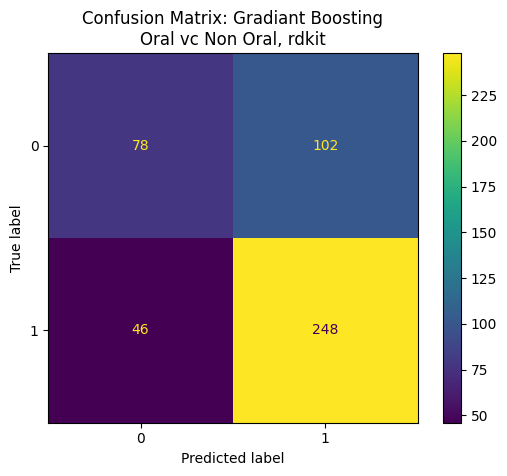

In [64]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

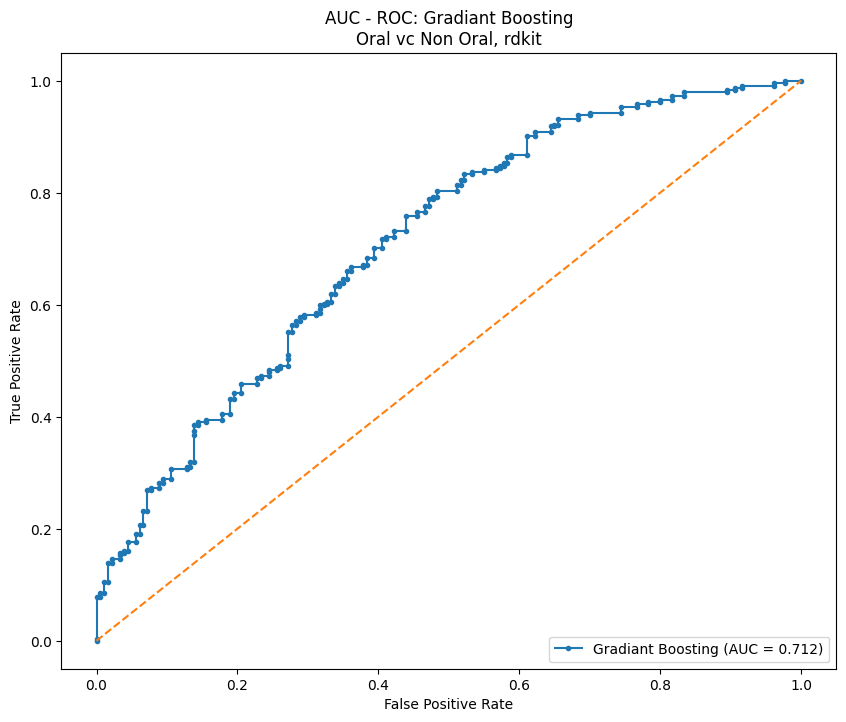

In [65]:
auc_boo = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boo_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

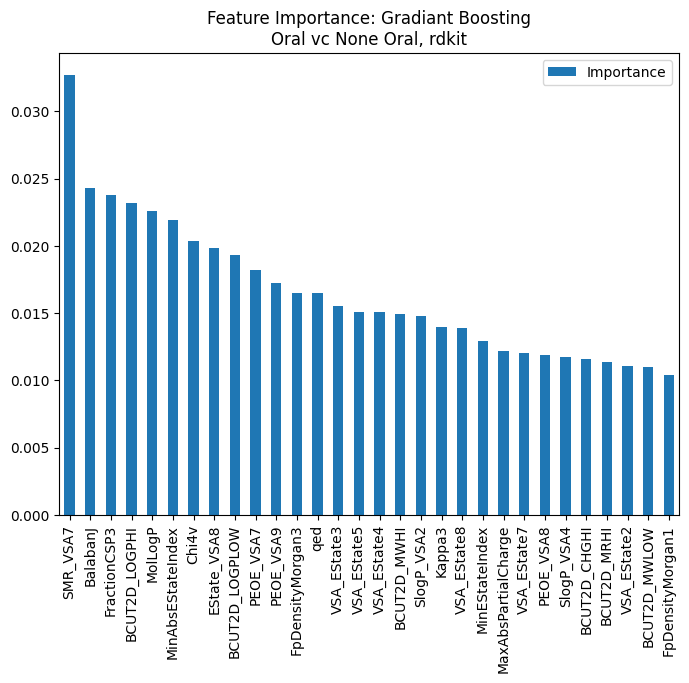

In [66]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(boosting.feature_importances_, index=x_train_scaled.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [67]:
important_features_boo = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_boo

,Importance
fr_benzodiazepine,1.924552e-17
Ipc,3.229987e-14
fr_SH,1.521109e-11
fr_barbitur,1.157285e-06
fr_nitro_arom,1.374337e-06
...,...
MolLogP,2.261301e-02
BCUT2D_LOGPHI,2.317503e-02
FractionCSP3,2.380254e-02
BalabanJ,2.431331e-02


## Saving Results

In [68]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_boo["best_score"][0],
    mis_rate_boo,
    auc_boo
]
final_results

,model_name,cv_auc,test_mis_rate,test_auc
0,Logistic Regression,0.656347,0.474684,0.498743
1,Decision Tree,0.623894,0.362869,0.632483
2,Random Forest,0.734871,0.312236,0.697194
3,Gradiant Boosting,0.725483,0.312236,0.712018


In [69]:
important_features_boo.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# BART

## Model Constant Variables

In [70]:
model_name_title = "BART"
model_name_path = "bart"

## Hyperparameter Fine Tuning

In [71]:
# transforming x train and test as arrays for BART procedure

x_train_bart = np.asarray(x_train)
x_test_bart = np.asarray(x_test)

In [72]:
model_params = {
    'BART': {
        'model': BART(),
        'params': {
            'num_trees': [100, 500, 1000],
            'max_stages': [100, 500, 800, 1000], # B, number of iterations
            'burnin': [5, 10, 20]
        }
    }
}

For BART, the auc present in the best_params_grid need to recieve the y_predicted in labels, but this BART algorithm does it in probabilities. Because of this, I need to use a custom scorer, that first transforms the prediction to labels.

In [73]:
score = make_scorer(bart_auc_scorer, greater_is_better=True)

gs_result_bart, gs_result_bart_full = best_params_grid(x_train_bart, y_train, model_params, scoring=score)

Starting Grid Search for BART: 13:55
Finished Grid Search for BART: 16:55
Tempo de execução:  179.7 minutos


In [74]:
gs_result_bart

,model,best_score,best_params
0,BART,0.608532,"{'burnin': 20, 'max_stages': 800, 'num_trees':..."


# Fitting Model

In [75]:
bart_params = gs_result_bart.iloc[0,2]
bart_params

{'burnin': 20, 'max_stages': 800, 'num_trees': 1000}

In [76]:
bart = BART(**bart_params)
bart.fit(x_train_bart, y_train)

BART(burnin=20, max_stages=800, num_trees=1000)

## Make Prediction

In [77]:
# the bart algorithm predicts as probabilities
y_predict_bart_prob = bart.predict(x_test_bart)

In [78]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

make_label_v = np.vectorize(make_label)
y_predict_bart_label = make_label_v(y_predict_bart_prob)

## Test Error

In [79]:
mis_rate_bart, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_bart_label,
)

Misclassification rate: 0.3186


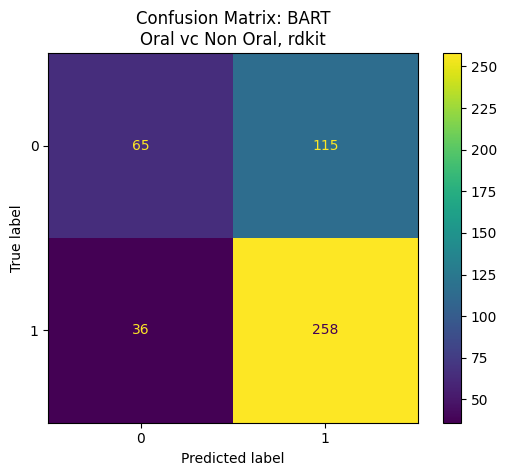

In [80]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

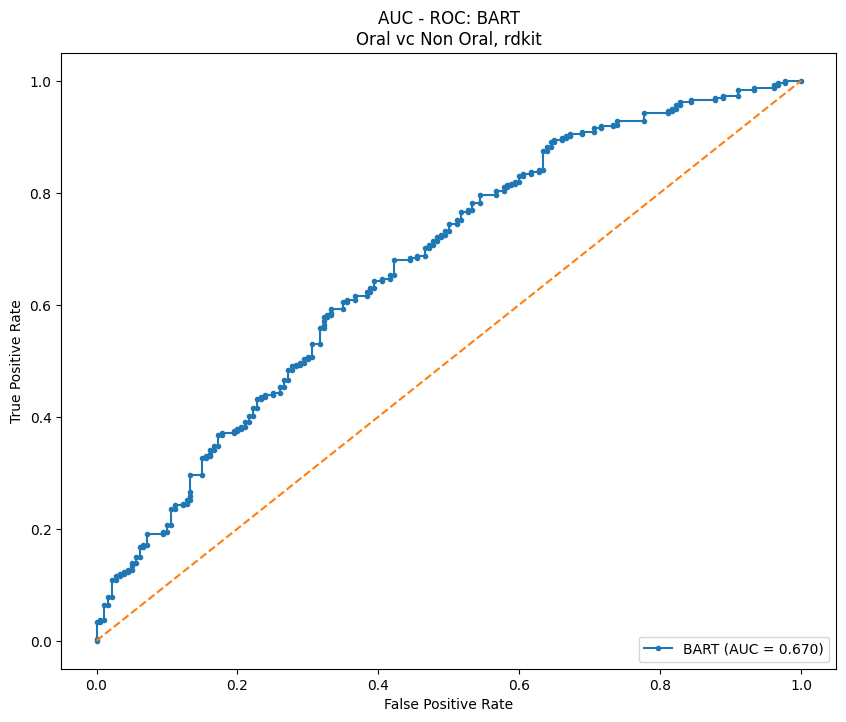

In [81]:
auc_bart = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_bart_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

We can check how many times each variable appeared in the collection
of trees. This gives a summary similar to the variable importance plot for
boosting and random forests.

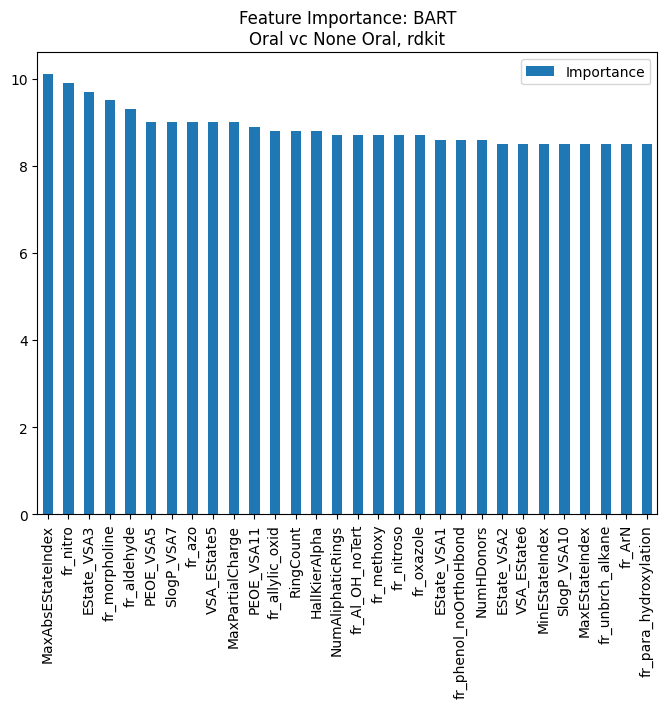

In [82]:
# Print the feature importances
fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(columns=["Importance"])
feat_importances["Importance"] = pd.Series(bart.variable_inclusion_.mean(0),index=X.columns).sort_values(ascending=False)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)


In [83]:
important_features_bart = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_bart

,Importance
fr_HOCCN,5.0
SMR_VSA5,5.5
SMR_VSA2,5.6
fr_Ar_N,5.7
fr_barbitur,5.8
...,...
fr_aldehyde,9.3
fr_morpholine,9.5
EState_VSA3,9.7
fr_nitro,9.9


## Saving Results

In [84]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_bart["best_score"][0],
    mis_rate_bart,
    auc_bart
]
final_results

,model_name,cv_auc,test_mis_rate,test_auc
0,Logistic Regression,0.656347,0.474684,0.498743
1,Decision Tree,0.623894,0.362869,0.632483
2,Random Forest,0.734871,0.312236,0.697194
3,Gradiant Boosting,0.725483,0.312236,0.712018
4,BART,0.608532,0.318565,0.669785


In [85]:
important_features_bart.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# SVM

## Model Constant Variables

In [86]:
model_name_title = "SVM"
model_name_path = "svm"

## Hyperparameter Fine Tuning

In [87]:
scale = 1 / (x_train.shape[1] * x_train.var().mean())

model_params = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 0.3, 0.5, 0.8, 1.0, 2, 5, 10],
            'kernel': ['rbf', 'sigmoid'],
            'gamma': ['auto', scale, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10]
        }
    }
}

In [88]:
gs_result_svm, gs_result_svm_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for SVM: 16:55
Finished Grid Search for SVM: 17:02
Tempo de execução:  6.3 minutos


## Fitting Model

In [89]:
svm_params = gs_result_svm.iloc[0,2]
svm_params

{'C': 0.8, 'gamma': 0.0001, 'kernel': 'rbf'}

In [90]:
svm = SVC(**svm_params, probability=True).fit(x_train, y_train)

## Make Prediction

In [91]:
y_predict_svm_label = svm.predict(x_test)
y_predict_svm_prob = svm.predict_proba(x_test)[:, 1]

## Test Error

In [92]:
mis_rate_svm, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_svm_label,
)

Misclassification rate: 0.3608


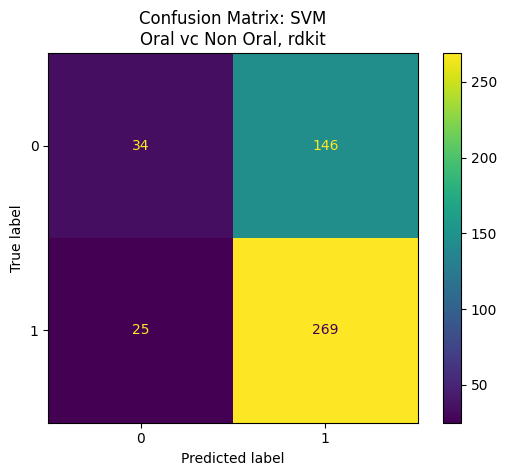

In [93]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

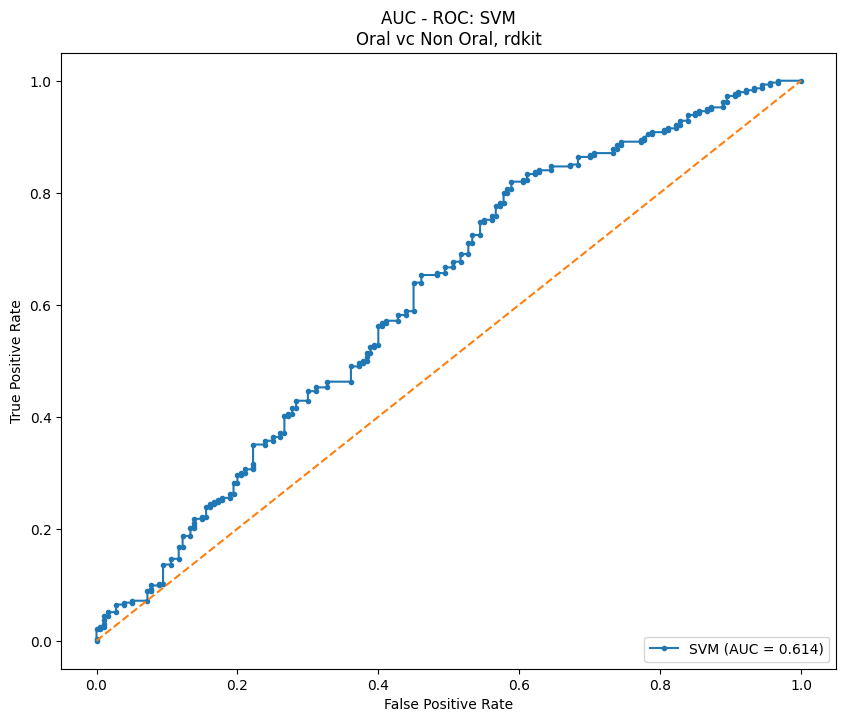

In [94]:
auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Saving Results

In [95]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_svm["best_score"][0],
    mis_rate_svm,
    auc_svm
]
final_results

,model_name,cv_auc,test_mis_rate,test_auc
0,Logistic Regression,0.656347,0.474684,0.498743
1,Decision Tree,0.623894,0.362869,0.632483
2,Random Forest,0.734871,0.312236,0.697194
3,Gradiant Boosting,0.725483,0.312236,0.712018
4,BART,0.608532,0.318565,0.669785
5,SVM,0.655551,0.360759,0.614210


# Saving Final Datasets

In [96]:
# saving final_results dataset
final_results.to_csv(f"final_results/models_results_{DESCRIPTOR_TYPE}.csv", index=False)

In [97]:
session_info.show()